In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import umap
from loader import ThumbnailDataset
import pandas as pd
from matplotlib.colors import LogNorm
import umap
from PIL import Image
import torchvision.transforms as transforms
from datasets import load_dataset

/opt/conda/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
name = 'mrbeast'
parent_dir = f'cruft/{name}_dash/raw'
files = sorted([parent_dir + '/' + f for f in os.listdir(parent_dir)], key=lambda x: int(x.split('_')[-1].split('.')[0]))
for f in files[:10]:
    print(f)

cruft/mrbeast_dash/raw/sae_activations_0.pt
cruft/mrbeast_dash/raw/sae_activations_256.pt
cruft/mrbeast_dash/raw/sae_activations_512.pt
cruft/mrbeast_dash/raw/sae_activations_768.pt


In [3]:
cutoff = 387 # around the 100,000 subscriber video, 9th July 2016
# cutoff = 9000
path = os.path.join('channel', name)
dataset = ThumbnailDataset(path, data_types=['numeric', 'thumbnail'], device='cpu')

views = dataset[:cutoff]['viewCount']
print(views.shape)
date = dataset[:cutoff]['publishedAt']
duration = dataset[:cutoff]['duration']

torch.Size([387])


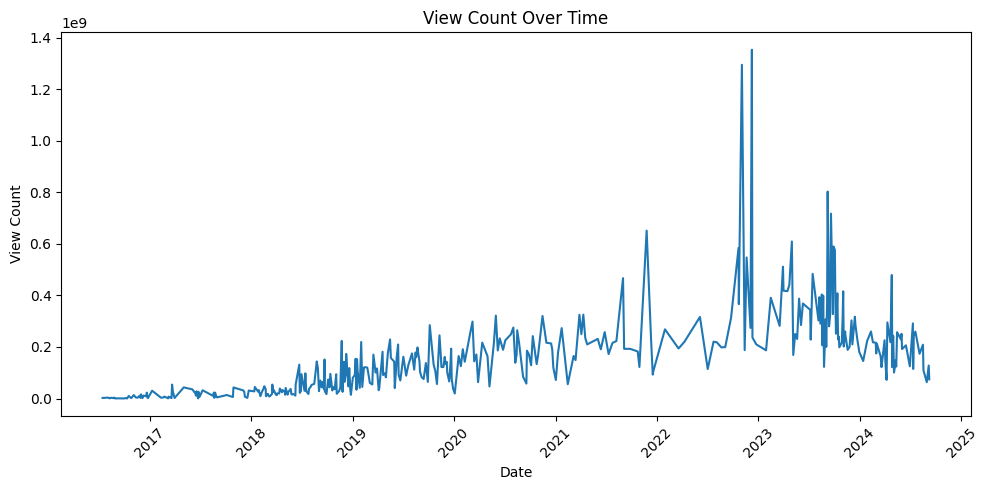

In [4]:
plt.figure(figsize=(10, 5))
plt.plot(pd.to_datetime(dataset[:cutoff]['publishedAt'], unit='s'), views)
plt.xlabel('Date')
plt.ylabel('View Count')
plt.title('View Count Over Time')
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.tight_layout()  # Adjust layout to make room for label rotation
plt.show()

In [5]:
stack = None

for f in files:
    data = torch.load(f).T
    if stack is None:
        stack = data
    else:
        stack = torch.cat((stack, data))

print(stack.shape)
stack = stack.cpu()
stack = stack[:cutoff]
print(stack.shape)

short_mask = duration > 61

views = views[short_mask]
stack = stack[short_mask]
date = date[short_mask]

print(stack.shape)

torch.Size([814, 65536])
torch.Size([387, 65536])
torch.Size([329, 65536])


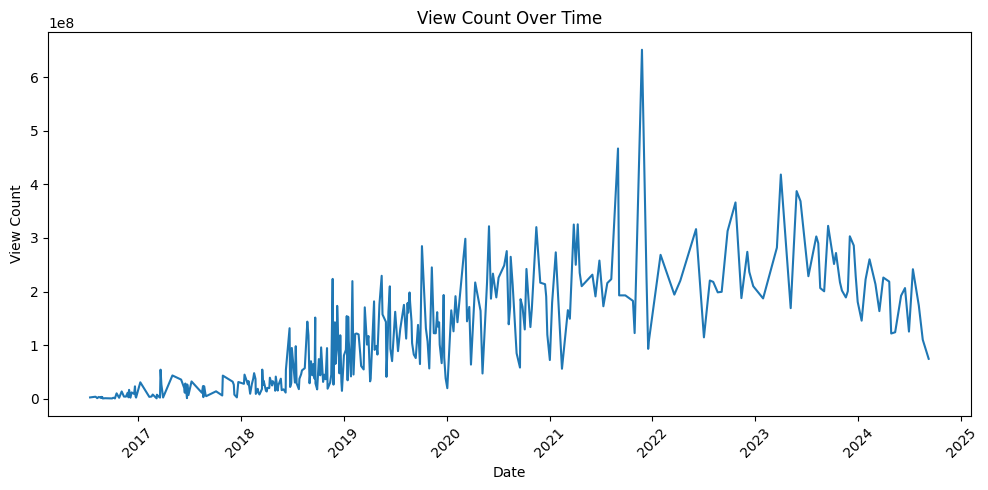

In [6]:
plt.figure(figsize=(10, 5))
plt.plot(pd.to_datetime(date, unit='s'), views)
plt.xlabel('Date')
plt.ylabel('View Count')
plt.title('View Count Over Time')
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.tight_layout()  # Adjust layout to make room for label rotation
plt.show()

In [7]:
binstack = stack > 0.05
binstacksum = binstack.sum(dim=0)
means = torch.zeros(stack.shape[1])
stds = torch.zeros(stack.shape[1])

for i in range(stack.shape[1]):
    if binstacksum[i] > 11:
        _, vid_indices = torch.topk(stack[:, i], 11)
        vid_indices = vid_indices[1:]
        active_vid_views = views[vid_indices]

        mean_views = active_vid_views.mean()

        means[i] = mean_views
        stds[i] = active_vid_views.std()

n_nonzero = (means > 0).sum()
print('number of features active on at least 11 videos:', n_nonzero.item())

topk = torch.topk(means, 10)

torch.set_printoptions(sci_mode=True)
print(topk.values)

number of features active on at least 11 videos: 147
tensor([2.4757e+08, 2.2644e+08, 2.1950e+08, 2.1681e+08, 2.1332e+08, 2.0571e+08,
        2.0513e+08, 2.0135e+08, 1.9908e+08, 1.9119e+08])


In [8]:
rand_means = []
rand_stds = []
for i in range(500):
    rand_idx = torch.randint(0, views.shape[0], (10,))

    rand_means.append(views[rand_idx].mean())
    rand_stds.append(views[rand_idx].std())

print('statistics for 500 random groups of 10 videos')
print(f'mean: {np.mean(rand_means):.2e} +- {np.std(rand_means):.2e} --- {np.mean(rand_means) + 2 * np.std(rand_means):.2e}/{np.mean(rand_means) - 2 * np.std(rand_means):.2e}')


statistics for 500 random groups of 10 videos
mean: 1.15e+08 +- 3.30e+07 --- 1.81e+08/4.87e+07


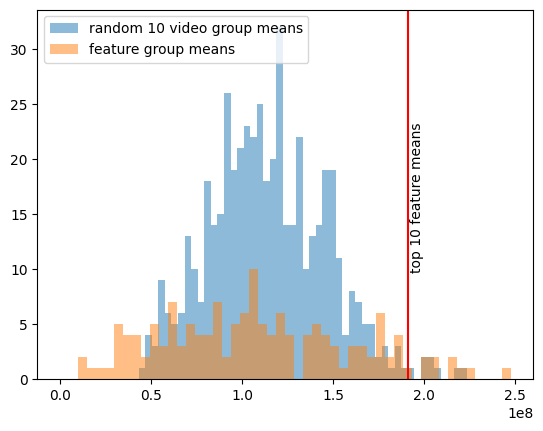

In [15]:
up_to = max(np.max(rand_means).item(), means.max().item()) + 1
plt.hist(rand_means, alpha=0.5, bins=50, label='random 10 video group means')
plt.hist(means, alpha=0.5, bins=50, range=(1, up_to), label='feature group means')

plt.axvline(x=topk.values[9].item(), color='r')
plt.text(topk.values[9].item() + 1e+6, 10, 'top 10 feature means', rotation=90)
plt.legend()



In [9]:
from scipy import stats

ks_statistic, ks_p_value = stats.ks_2samp(means, rand_means)
ks_statistic, ks_p_value 

(0.9977569580078125, 0.0)

tensor(1.6295e+08)


1.15e+08, +- 3.20e+07
chance of randomly getting topk mean or higher: %7.3


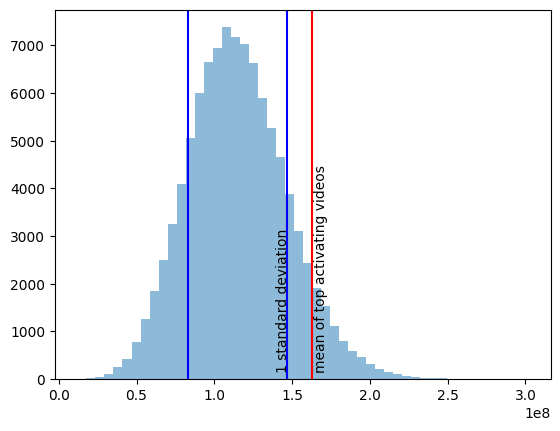

In [16]:

top_views = torch.zeros(10)
for i, feature_idx in enumerate(topk.indices):
    _, vid_indices = torch.topk(stack[:, feature_idx], 11)
    active_vid_views = views[vid_indices[0]]
    top_views[i] = active_vid_views

print(top_views.mean())

rand_11 = []
for i in range(100_000):
    rand_views = views[torch.randint(0, views.shape[0], (10,))]
    rand_11.append(rand_views.mean())

print(f'{np.mean(rand_11):.2e}, +- {np.std(rand_11):.2e}')

plt.hist(rand_11, alpha=0.5, bins=50)

plt.axvline(np.mean(rand_11) + np.std(rand_11), color='b')
plt.axvline(np.mean(rand_11) - np.std(rand_11), color='b')

plt.axvline(top_views.mean(), color='r')
p = (np.array(rand_11) > top_views.numpy().mean()).sum() / len(rand_11)

print(f"chance of randomly getting topk mean or higher: %{round(p * 100, 2)}", )

plt.text(np.mean(rand_11) + np.std(rand_11) - 7500000, 200,  '1 standard deviation', rotation=90)
plt.text(top_views.mean() + 1000000, 200,  'mean of top activating videos', rotation=90)

plt.show()


In [17]:
intopk = torch.zeros(views.shape[0])

for i in topk.indices:
    _, vid_indices = torch.topk(stack[:, i], 10)

    intopk[vid_indices] = 1

Text(0.5, 1.0, 'videos activating any of the top 10 features')

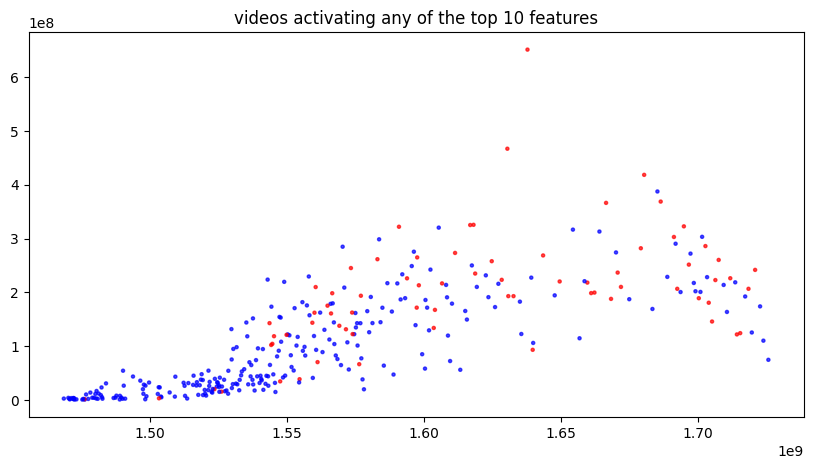

In [18]:
plt.figure(figsize=(10, 5))
plt.scatter(date, views, c=intopk, cmap='bwr', s=5, alpha=0.7)
plt.title("videos activating any of the top 10 features")

In [13]:
all_thumbnails = dataset[:cutoff]['thumbnail']
all_thumbnails = all_thumbnails[short_mask]

In [14]:
imgnet_max_indices = torch.load('cruft/imgnet_dash/max_activating_image_indices.pt', map_location='cpu')
imgnet = load_dataset("evanarlian/imagenet_1k_resized_256", split='train')
imgnet = imgnet.shuffle(seed=1)

Resolving data files:   0%|          | 0/52 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/52 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/39 [00:00<?, ?it/s]

In [15]:
def show_images(tensor_images, pil_images, num_cols=4, save_path='path/to/save/grid.png', show=False):
    transform = transforms.ToPILImage()
    
    # Determine the grid dimensions
    num_tensor_rows = (len(tensor_images) + num_cols - 1) // num_cols  # Compute rows needed for tensor images
    num_pil_rows = (len(pil_images) + num_cols - 1) // num_cols        # Compute rows needed for PIL images
    num_rows = num_tensor_rows + num_pil_rows                         # Total rows

    # Determine height and width from the first tensor image if available, else from the first PIL image

    height = tensor_images[0].shape[0]
    width = tensor_images[0].shape[1]

    # Create a blank grid image
    grid_image = Image.new('RGB', (width * num_cols, height * num_rows))

    # Insert tensor images into the grid
    for i, img_tensor in enumerate(tensor_images):
        img = transform(img_tensor.permute(2, 0, 1))  # Adjust tensor for PIL and convert to image
        x = i % num_cols * width
        y = i // num_cols * height
        grid_image.paste(img, (x, y))

    # Insert PIL images directly below the last row of tensor images
    for j, img in enumerate(pil_images):
        x = j % num_cols * width
        y = (j // num_cols + num_tensor_rows) * height  # Adjust y to start after the tensor image rows
        grid_image.paste(img, (x, y))

    # Save the grid image to disk
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    grid_image.save(save_path)
    print(f'Grid image saved: {save_path}')

    if show:
        # Display the grid image
        plt.figure(figsize=(15, 10))
        plt.imshow(grid_image)
        plt.axis('off')
        plt.show()

In [17]:
for i, feature_idx in enumerate(topk.indices):
    feature_mean = topk.values[i]
    print(f"feature {feature_idx} mean: {feature_mean}")
    _, vid_indices = torch.topk(stack[:, feature_idx], 11)

    vid_tensors = all_thumbnails[vid_indices]
    imgnet_indices = imgnet_max_indices[feature_idx][:11]

    imgnet_imgs = []
    for idx in imgnet_indices:
        img = imgnet[int(idx.item())]['image']
        imgnet_imgs.append(img)

    show_images(vid_tensors, imgnet_imgs, 4, f"cruft/images/{feature_idx}_grid_image.png", show=False)


feature 35679 mean: 247572192.0


Grid image saved: cruft/images/35679_grid_image.png
feature 59281 mean: 226439808.0
Grid image saved: cruft/images/59281_grid_image.png
feature 8400 mean: 219503392.0
Grid image saved: cruft/images/8400_grid_image.png
feature 15555 mean: 216806352.0
Grid image saved: cruft/images/15555_grid_image.png
feature 8971 mean: 213322928.0
Grid image saved: cruft/images/8971_grid_image.png
feature 20293 mean: 205707680.0
Grid image saved: cruft/images/20293_grid_image.png
feature 14500 mean: 205130160.0
Grid image saved: cruft/images/14500_grid_image.png
feature 45019 mean: 201347184.0
Grid image saved: cruft/images/45019_grid_image.png
feature 16059 mean: 199083200.0
Grid image saved: cruft/images/16059_grid_image.png
feature 53529 mean: 191192224.0
Grid image saved: cruft/images/53529_grid_image.png


In [20]:
print(views.mean().item())

114782920.0
